
# 00 — Exploración inicial del dataset (EDA)

## Objetivo del notebook
Este notebook presenta una **exploración sistemática de los datos medidos** en una tubería instrumentada con sensores de presión y caudal, sin asumir a priori el mecanismo de falla.

El propósito es:
- Caracterizar la estructura y calidad de los datos
- Identificar escalas temporales relevantes
- Obtener estadística descriptiva robusta
- Preparar el dataset para análisis físico posteriores (transientes, ciclos, fatiga)

El análisis se limita deliberadamente a **describir lo observado**, dejando la interpretación física detallada para notebooks posteriores.

---

## Alcance y limitaciones del muestreo
Los datos están muestreados a una escala del orden de **minutos**.  
Por lo tanto:

- Se capturan adecuadamente **cambios de régimen, rampas, escalones y ciclos operacionales**
- No se resuelven transientes hidráulicos de escala de **segundos** (por ejemplo, picos instantáneos de golpe de ariete)

Esto se tendrá en cuenta en la interpretación posterior.

---

## Glosario de notación

A lo largo del proyecto se utilizará la siguiente notación:

### Variables hidráulicas
- $Q$: caudal volumétrico  
  - $Q$ en L/s  
  - $Q$ en m³/s cuando se indica explícitamente  
- $h$: carga hidráulica en metros de columna de agua (mca)
- $P$: presión
  - $P$ en Pa, kPa o bar según el contexto

La conversión entre carga y presión se realiza mediante:

$$
P = \rho_f \, g \, h
$$

donde:
- $\rho_f$: densidad del fluido (agua: $\rho_f \approx 1000\ \mathrm{kg/m^3}$)
- $g$: aceleración de la gravedad ($g \approx 9.81\ \mathrm{m/s^2}$)

---

### Incrementos temporales
Dado el muestreo discreto, se definen los incrementos entre muestras consecutivas como:

$$
\Delta P = P(t) - P(t-\Delta t)
$$

$$
\Delta Q = Q(t) - Q(t-\Delta t)
$$

donde $\Delta t$ corresponde al intervalo de muestreo efectivo.

---

### Magnitudes estadísticas
- $s_{\mathrm{rob}}$: escala estadística robusta (basada en MAD), utilizada para caracterizar la magnitud típica de las fluctuaciones de una señal
- $\mathrm{MAD}$: desviación absoluta mediana (*Median Absolute Deviation*)

Estas magnitudes **no representan esfuerzos mecánicos**.

---

### Esfuerzos mecánicos (cuando se utilicen)
- $\sigma_\theta$: esfuerzo circunferencial (hoop stress) en la pared de la tubería

---

## Estructura del análisis en este notebook
1. Carga y limpieza básica del dataset
2. Identificación de la variable temporal y frecuencia real de muestreo
3. Estadística descriptiva de presión y caudal
4. Evaluación de calidad de datos (missing, ceros, outliers)
5. Análisis temporal exploratorio
6. Cálculo de incrementos $\Delta P$ y $\Delta Q$
7. Preparación del dataset base para análisis posteriores

---



In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

PROJECT_ROOT = Path('/home/maxi/datascience_esval')
RAW_FILE = PROJECT_ROOT / 'data' / 'raw' / 'DATOS SENSORES.xlsx'
RAW_FILE.exists(), RAW_FILE


(True, PosixPath('/home/maxi/datascience_esval/data/raw/DATOS SENSORES.xlsx'))

## 1) Carga del dataset

Leemos el Excel, estandarizamos nombres de columnas y miramos forma general.


In [2]:
df_raw = pd.read_excel(RAW_FILE, sheet_name=0, engine='openpyxl')
df_raw.columns = [str(c).strip().lower().replace(' ', '_') for c in df_raw.columns]
df_raw.shape, df_raw.columns.tolist()


((475141, 3), ['fecha_y_hora', 'caudal_copa_(l/s)', 'pe_booster_auco_(mca)'])

In [3]:
df_raw.head()

,fecha_y_hora,caudal_copa_(l/s),pe_booster_auco_(mca)
0,2025-01-01 00:00:00,45.44,17.6868
1,2025-01-01 00:01:00,43.88,17.7582
2,2025-01-01 00:02:00,41.79,17.9418
3,2025-01-01 00:03:00,42.15,17.9520
4,2025-01-01 00:04:00,43.16,17.7276


## 2) Columna temporal y muestreo real

- Detectamos la columna de tiempo (si existe)
- Ordenamos por tiempo y revisamos:
  - paso temporal típico
  - duplicados
  - gaps (saltos grandes)


In [4]:
def find_datetime_column(df):
    keys = ['time', 'fecha', 'date', 'timestamp', 'hora']
    best = (None, 0.0)
    for c in df.columns:
        if any(k in c for k in keys):
            parsed = pd.to_datetime(df[c], errors='coerce')
            score = float(parsed.notna().mean())
            if score > best[1]:
                best = (c, score)
    return best

time_col, score = find_datetime_column(df_raw)
time_col, score


('fecha_y_hora', 1.0)

In [5]:
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col]).sort_values(time_col).set_index(time_col)
df.index.name = 't'

# dt en segundos
dt = df.index.to_series().diff().dt.total_seconds()

print('Rango:', df.index.min(), '->', df.index.max())
print('Duplicados timestamp:', int(df.index.duplicated().sum()))
dt.describe()


Rango: 2025-01-01 00:00:00 -> 2025-11-27 00:00:00
Duplicados timestamp: 0


count    475140.000000
mean         60.007577
std           5.222659
min          60.000000
25%          60.000000
50%          60.000000
75%          60.000000
max        3660.000000
Name: t, dtype: float64

In [6]:
# Gaps > 5 min (300s)
gaps = dt[dt > 300].dropna().sort_values(ascending=False)
print('n_gaps > 5min:', len(gaps))
gaps.head(10)


n_gaps > 5min: 1


t
2025-09-07 01:00:00    3660.0
Name: t, dtype: float64

## 3) Identificar variables físicas (candidatas)

Buscamos columnas numéricas, y tratamos de inferir:
- caudal \(Q\)
- carga/presión \(h\) o \(P\)


In [7]:
num = df.select_dtypes(include=[np.number]).copy()
print('Columnas numéricas:', num.columns.tolist())
display(num.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T)


Columnas numéricas: ['caudal_copa_(l/s)', 'pe_booster_auco_(mca)']


,count,mean,std,min,1%,5%,50%,95%,99%,max
caudal_copa_(l/s),464629.0,49.453575,19.541651,0.0,16.7600,19.2500,50.130,80.2400,89.4600,99.0000
pe_booster_auco_(mca),462468.0,14.921524,2.692492,0.0,9.3534,9.9042,15.504,18.6558,20.2062,22.4706


### Selección de columnas (auto + editable)

Intentamos detectar automáticamente:
- `Q_COL`: columna de caudal (L/s)
- `H_COL`: columna de carga en mca (o presión equivalente)

Si la detección no acierta, edítalo manualmente.


In [8]:
def pick_col_by_keywords(cols, keywords):
    for c in cols:
        lc = c.lower()
        if any(k in lc for k in keywords):
            return c
    return None

Q_COL = pick_col_by_keywords(num.columns, ['caudal', 'flow', 'q'])
H_COL = pick_col_by_keywords(num.columns, ['mca', 'pres', 'pressure', 'pe_', 'carga', 'head'])

Q_COL, H_COL


('caudal_copa_(l/s)', 'pe_booster_auco_(mca)')

In [ ]:
# Si quieres forzar manualmente, descomenta y ajusta:
# Q_COL = 'caudal_copa_(l/s)'
# H_COL = 'pe_booster_auco_(mca)'

print('Q_COL =', Q_COL)
print('H_COL =', H_COL)


## 4) Unidades y conversiones

Si `H_COL` está en mca (metros columna de agua), convertimos:

\[
P = \rho_f g h
\]

Usamos por defecto agua:
- \(\rho_f = 1000\,kg/m^3\)
- \(g=9.80665\,m/s^2\)

y calculamos:
- \(P_{Pa}\), \(P_{kPa}\), \(P_{bar}\)
- \(Q\) de L/s a m³/s


In [9]:
rho_f = 1000.0
g = 9.80665

work = df.copy()

if Q_COL is not None:
    work['q_lps'] = work[Q_COL]
    work['q_m3s'] = work['q_lps'] / 1000.0

if H_COL is not None:
    work['h_mca'] = work[H_COL]
    work['p_pa'] = rho_f * g * work['h_mca']
    work['p_kpa'] = work['p_pa'] / 1000.0
    work['p_bar'] = work['p_pa'] / 1e5

work[['q_lps','q_m3s','h_mca','p_kpa','p_bar']].describe().T


,count,mean,std,min,25%,50%,75%,max
q_lps,464629.0,49.453575,19.541651,0.0,31.860000,50.130000,64.700000,99.000000
q_m3s,464629.0,0.049454,0.019542,0.0,0.031860,0.050130,0.064700,0.099000
h_mca,462468.0,14.921524,2.692492,0.0,13.525200,15.504000,16.666800,22.470600
p_kpa,462468.0,146.330164,26.404324,0.0,132.636903,152.042302,163.445474,220.361309
p_bar,462468.0,1.463302,0.264043,0.0,1.326369,1.520423,1.634455,2.203613


## 5) Calidad de datos (missing, ceros, outliers)

- Porcentaje de missing por variable
- Porcentaje de ceros
- Detección simple de outliers por percentiles


In [10]:
cols_check = []
for c in ['q_lps','h_mca','p_bar']:
    if c in work.columns:
        cols_check.append(c)

miss = work[cols_check].isna().mean()
zeros = (work[cols_check] == 0).mean()

print('Missing rate:')
display(miss)

print('Zero rate:')
display(zeros)

print('Percentiles:')
display(work[cols_check].describe(percentiles=[0.001,0.01,0.05,0.5,0.95,0.99,0.999]).T)


Missing rate:


q_lps    0.022124
h_mca    0.026672
p_bar    0.026672
dtype: float64

Zero rate:


q_lps    0.000013
h_mca    0.000450
p_bar    0.000450
dtype: float64

Percentiles:


,count,mean,std,min,0.1%,1%,5%,50%,95%,99%,99.9%,max
q_lps,464629.0,49.453575,19.541651,0.0,13.970000,16.760000,19.25000,50.130000,80.240000,89.460000,98.410000,99.000000
h_mca,462468.0,14.921524,2.692492,0.0,2.840363,9.353400,9.90420,15.504000,18.655800,20.206200,20.614200,22.470600
p_bar,462468.0,1.463302,0.264043,0.0,0.278544,0.917255,0.97127,1.520423,1.829509,1.981551,2.021562,2.203613


## 6) Series temporales: vistas globales

- Gráficos en 1 minuto (tal cual)
- Promedio 1 hora para tendencia


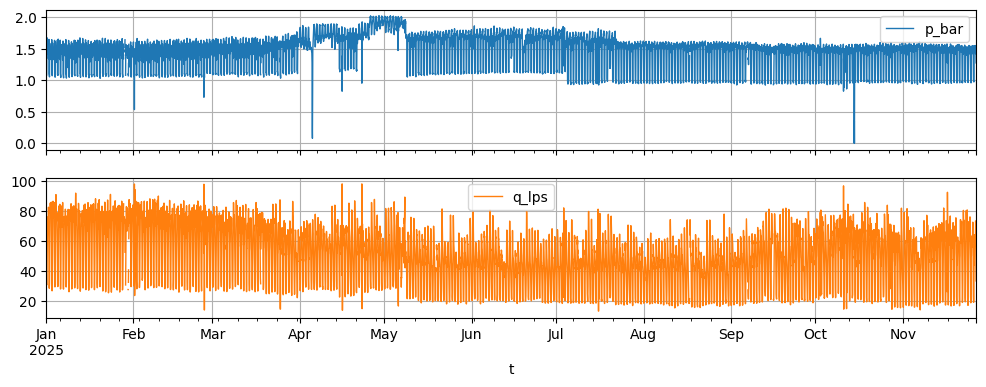

In [11]:
plot_cols = []
if 'p_bar' in work.columns: plot_cols.append('p_bar')
if 'q_lps' in work.columns: plot_cols.append('q_lps')

work_1h = work[plot_cols].resample('1h').mean(numeric_only=True)

axes = work_1h.plot(subplots=True, linewidth=1)
plt.show()


## 7) Cambios entre muestras: \(\Delta P\) y \(\Delta Q\)

Como el muestreo puede ser 1 minuto, aquí definimos:

\[
\Delta P_{1min} = P(t)-P(t-1min),\quad \Delta Q_{1min} = Q(t)-Q(t-1min)
\]

Esto sirve para:
- detectar escalones y maniobras a escala minuto
- cuantificar “agitación” operacional (variabilidad)

**No** representa el pico máximo de un transiente de segundos.


In [12]:
if 'p_bar' in work.columns:
    work['dP_bar'] = work['p_bar'].diff()
if 'q_lps' in work.columns:
    work['dQ_lps'] = work['q_lps'].diff()

delta_cols = [c for c in ['dP_bar','dQ_lps'] if c in work.columns]
work[delta_cols].describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]).T


,count,mean,std,min,1%,5%,50%,95%,99%,99.9%,max
dP_bar,460566.0,7.405994e-07,0.040569,-1.534427,-0.076021,-0.044012,0.0,0.044012,0.078022,0.32309,1.283357
dQ_lps,463444.0,4.022492e-04,2.103507,-82.410000,-3.360000,-1.790000,0.0,1.790000,3.475700,21.15557,82.500000


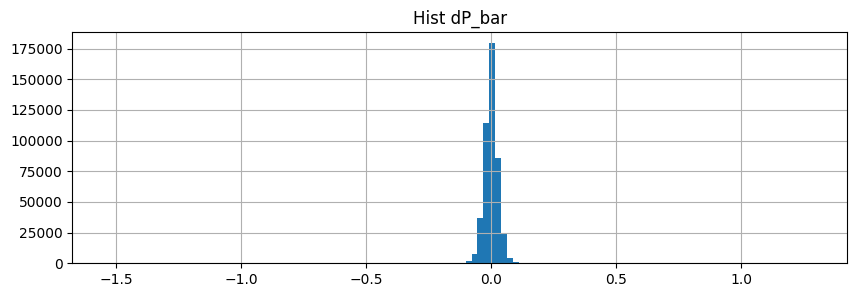

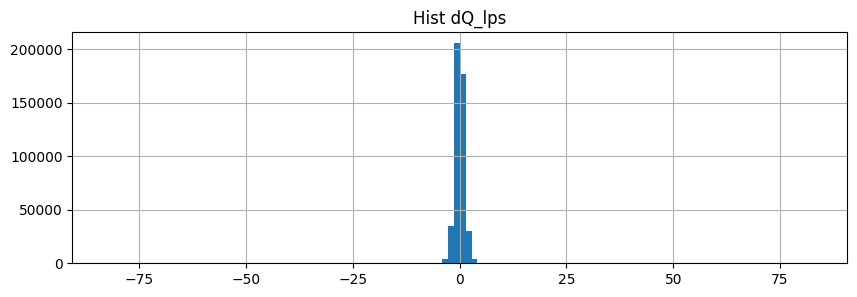

In [13]:
for c in ['dP_bar','dQ_lps']:
    if c in work.columns:
        plt.figure(figsize=(10,3))
        x = work[c].dropna()
        plt.hist(x, bins=120)
        plt.title(f'Hist {c}')
        plt.show()


## 8) Patrones operacionales (hora del día / día de semana)

Buscamos:
- ciclos diarios (demanda)
- cambios de régimen por control


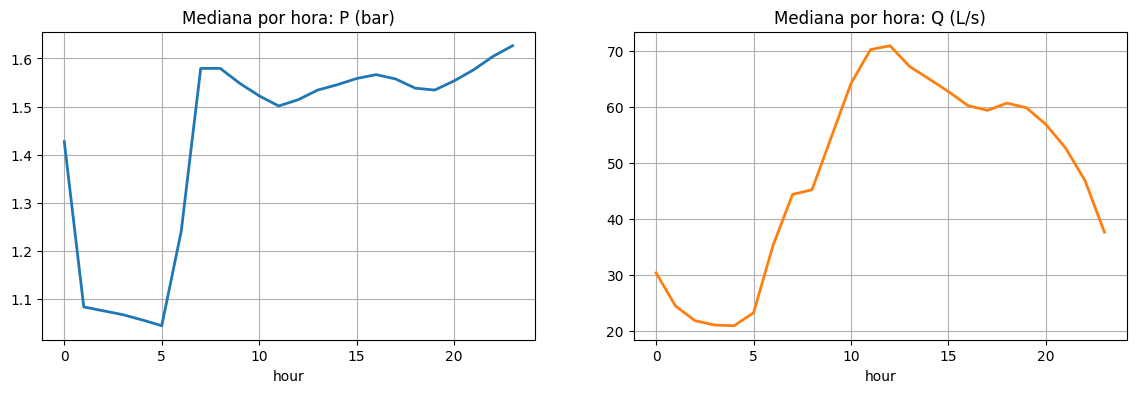

In [14]:
tmp = work.copy()
tmp['hour'] = tmp.index.hour
tmp['dow'] = tmp.index.dayofweek

out = {}
if 'p_bar' in tmp.columns:
    out['p_by_hour'] = tmp.groupby('hour')['p_bar'].median()
if 'q_lps' in tmp.columns:
    out['q_by_hour'] = tmp.groupby('hour')['q_lps'].median()

fig, ax = plt.subplots(1,2, figsize=(14,4))
if 'p_by_hour' in out:
    out['p_by_hour'].plot(ax=ax[0], linewidth=2)
    ax[0].set_title('Mediana por hora: P (bar)')
if 'q_by_hour' in out:
    out['q_by_hour'].plot(ax=ax[1], linewidth=2, color='tab:orange')
    ax[1].set_title('Mediana por hora: Q (L/s)')
plt.show()


## 9) Guardar dataset base para notebooks siguientes (opcional pero recomendado)

Guardamos un parquet liviano con:
- índice temporal limpio
- columnas normalizadas (q_lps, q_m3s, p_bar, etc.)
- deltas (dP_bar, dQ_lps)

Esto acelera notebooks siguientes y evita releer Excel.


In [15]:
OUT_DIR = PROJECT_ROOT / 'data' / 'processed'
OUT_DIR.mkdir(parents=True, exist_ok=True)

base_cols = [c for c in ['q_lps','q_m3s','h_mca','p_kpa','p_bar','dP_bar','dQ_lps'] if c in work.columns]
BASE_FILE = OUT_DIR / 'sensores_base.parquet'

work[base_cols].to_parquet(BASE_FILE)
BASE_FILE, work[base_cols].shape


(PosixPath('/home/maxi/datascience_esval/data/processed/sensores_base.parquet'),
 (475141, 7))

## Resumen de datos (para pegar en el chat)

Esta celda imprime un resumen compacto del dataset y de las variables físicas.


In [16]:
print('=== RESUMEN DATASET (00) ===')
print('Archivo:', RAW_FILE)
print('Filas/Cols crudas:', df_raw.shape)
print('Columnas:', df_raw.columns.tolist())

print('\nTiempo:')
print('time_col:', time_col, '| parse_score:', score)
print('Rango:', df.index.min(), '->', df.index.max())
print('Duplicados timestamp:', int(df.index.duplicated().sum()))
print('dt (seg) describe:')
print(dt.describe())

print('\nVariables detectadas:')
print('Q_COL:', Q_COL)
print('H_COL:', H_COL)

cols_check = [c for c in ['q_lps','h_mca','p_bar','dP_bar','dQ_lps'] if c in work.columns]
print('\nMissing rate:')
print(work[cols_check].isna().mean())

print('\nZero rate:')
print((work[cols_check] == 0).mean())

print('\nPercentiles clave:')
if 'q_lps' in work.columns:
    print('Q (L/s):')
    print(work['q_lps'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]))
if 'p_bar' in work.columns:
    print('\nP (bar):')
    print(work['p_bar'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]))
if 'dP_bar' in work.columns:
    print('\nΔP por muestra (bar):')
    print(work['dP_bar'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]))
if 'dQ_lps' in work.columns:
    print('\nΔQ por muestra (L/s):')
    print(work['dQ_lps'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]))

print('\nParquet base:', BASE_FILE if 'BASE_FILE' in globals() else '(no guardado)')
print('=== FIN ===')


=== RESUMEN DATASET (00) ===
Archivo: /home/maxi/datascience_esval/data/raw/DATOS SENSORES.xlsx
Filas/Cols crudas: (475141, 3)
Columnas: ['fecha_y_hora', 'caudal_copa_(l/s)', 'pe_booster_auco_(mca)']

Tiempo:
time_col: fecha_y_hora | parse_score: 1.0
Rango: 2025-01-01 00:00:00 -> 2025-11-27 00:00:00
Duplicados timestamp: 0
dt (seg) describe:
count    475140.000000
mean         60.007577
std           5.222659
min          60.000000
25%          60.000000
50%          60.000000
75%          60.000000
max        3660.000000
Name: t, dtype: float64

Variables detectadas:
Q_COL: caudal_copa_(l/s)
H_COL: pe_booster_auco_(mca)

Missing rate:
q_lps     0.022124
h_mca     0.026672
p_bar     0.026672
dP_bar    0.030675
dQ_lps    0.024618
dtype: float64

Zero rate:
q_lps     0.000013
h_mca     0.000450
p_bar     0.000450
dP_bar    0.021375
dQ_lps    0.011971
dtype: float64

Percentiles clave:
Q (L/s):
count    464629.000000
mean         49.453575
std          19.541651
min           0.000000
1% 